# 02 - Pré-processamento de Dados
## Tech Challenge Fase 4 - Previsão de Ações com LSTM

Este notebook demonstra o pré-processamento dos dados para o modelo LSTM.

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from src.data.data_loader import StockDataLoader
from src.data.preprocessor import DataPreprocessor

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (15, 8)

## 1. Configurações

In [2]:
# Símbolo da ação
SYMBOL = 'AAPL'
START_DATE = '2018-01-01'
END_DATE = '2024-01-01'

# Parâmetros do preprocessamento
SEQUENCE_LENGTH = 60
TRAIN_SPLIT = 0.8

## 2. Carregar Dados

In [3]:
print(f"Carregando dados de {SYMBOL}...")
loader = StockDataLoader(SYMBOL, START_DATE, END_DATE, allow_synthetic=False)
df = loader.fetch_data()

print(f"\nDados carregados: {len(df)} registros")
print(f"Período: {df.index[0]} até {df.index[-1]}")
print(f"Fonte: {loader.get_source()}")

df.head()

Carregando dados de AAPL...



Dados carregados: 792 registros
Período: 2020-11-05 00:00:00 até 2023-12-29 00:00:00
Fonte: stooq_reader


,Open,High,Low,Close,Volume
Date,,,,,
2020-11-05,115.010,116.643,113.964,116.061,129614631
2020-11-06,115.571,116.439,113.432,115.933,117178682
2020-11-09,117.707,119.157,113.353,113.616,158188274
2020-11-10,112.859,114.852,111.478,113.274,141304322
2020-11-11,114.474,116.861,113.736,116.722,114964300


## 3. Adicionar Indicadores Técnicos

In [4]:
# Adicionar indicadores técnicos
df_with_indicators = loader.add_technical_indicators(df)

print(f"Dados após indicadores: {len(df_with_indicators)} registros")
print(f"Colunas: {list(df_with_indicators.columns)}")

df_with_indicators.tail()

Dados após indicadores: 773 registros
Colunas: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_20', 'EMA_10', 'EMA_20', 'RSI_14', 'MACD', 'MACD_signal', 'BB_upper', 'BB_lower']


,Open,High,Low,Close,Volume,SMA_10,SMA_20,EMA_10,EMA_20,RSI_14,MACD,MACD_signal,BB_upper,BB_lower
Date,,,,,,,,,,,,,,
2023-12-22,194.015,194.244,191.818,192.444,37372611,194.5789,192.51275,193.793906,192.165155,54.671435,2.642180,3.246372,198.300056,186.725444
2023-12-26,192.454,192.733,191.679,191.898,29092938,194.5660,192.67480,193.449196,192.139712,53.090620,2.312669,3.059632,198.182253,187.167347
2023-12-27,191.342,192.345,189.949,191.998,48376393,194.4110,192.81155,193.185342,192.126215,53.356633,2.036127,2.854931,198.093513,187.529587
2023-12-28,192.981,193.499,192.018,192.424,34254329,193.9755,193.02070,193.046916,192.154576,54.539329,1.830243,2.649993,197.852748,188.188652
2023-12-29,192.743,193.240,190.581,191.382,42928346,193.4209,193.14900,192.744204,192.080997,51.124603,1.564957,2.432986,197.634835,188.663165


## 4. Visualizar Indicadores

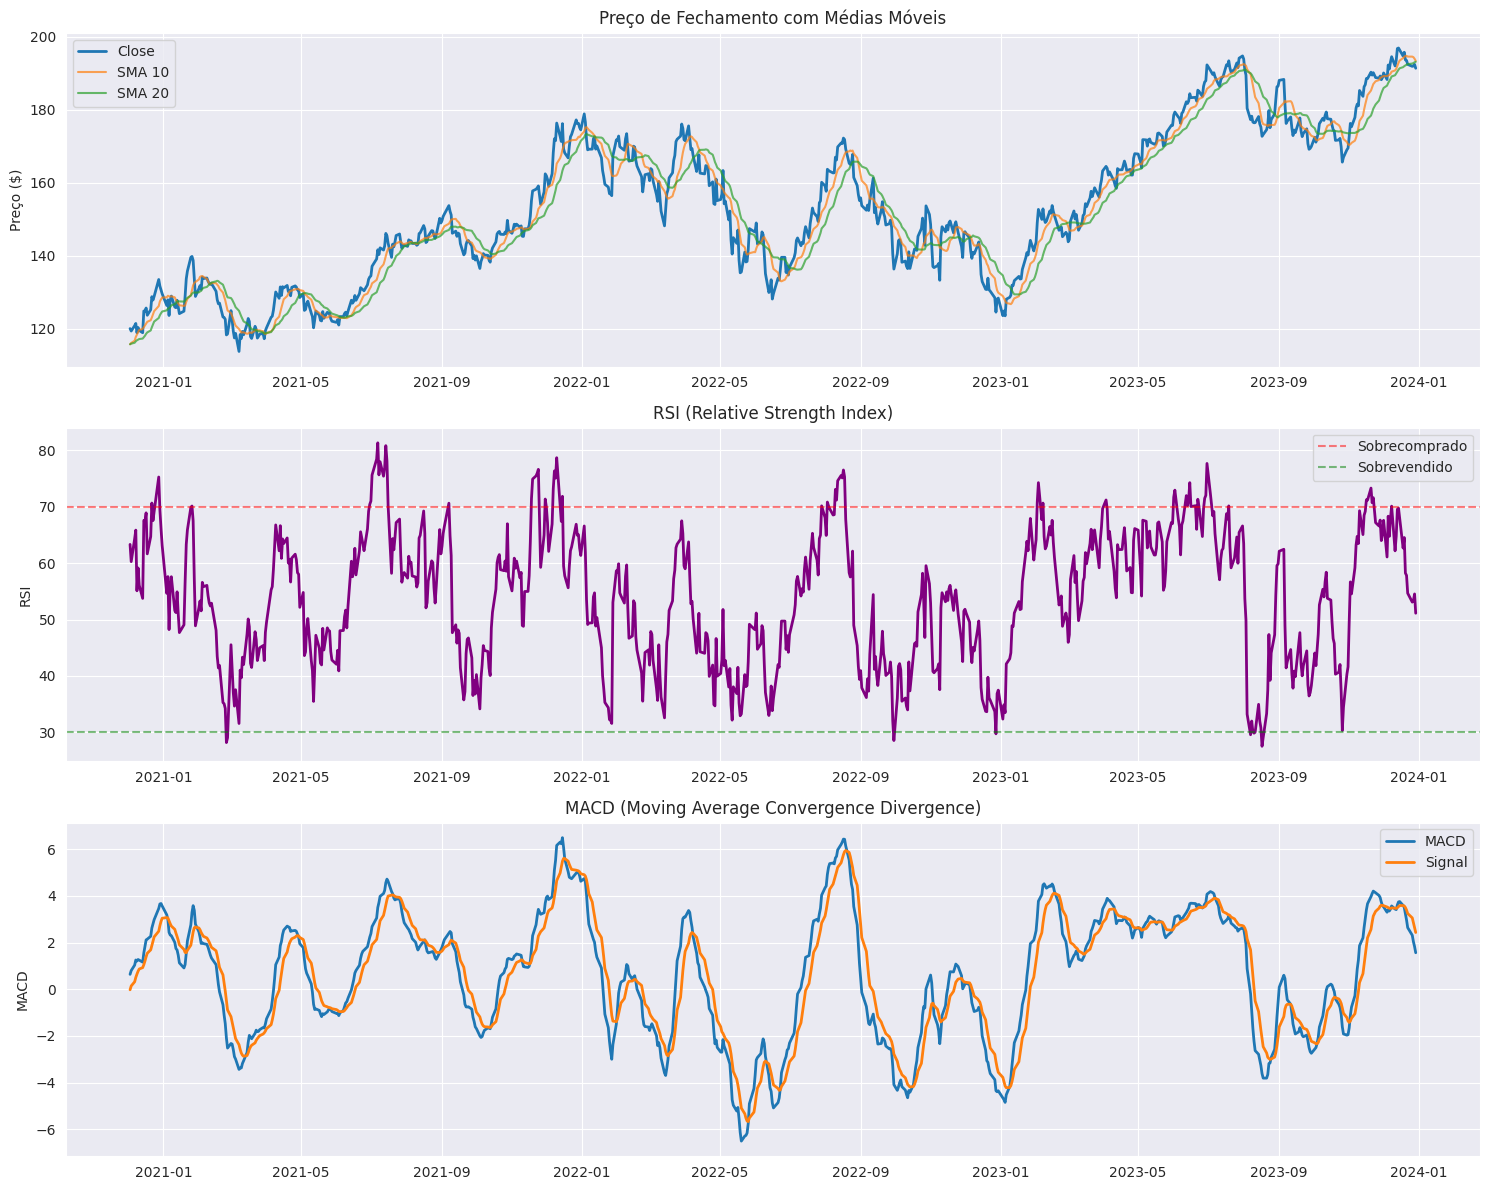

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Preço com médias móveis
axes[0].plot(df_with_indicators.index, df_with_indicators['Close'], label='Close', linewidth=2)
axes[0].plot(df_with_indicators.index, df_with_indicators['SMA_10'], label='SMA 10', alpha=0.7)
axes[0].plot(df_with_indicators.index, df_with_indicators['SMA_20'], label='SMA 20', alpha=0.7)
axes[0].set_title('Preço de Fechamento com Médias Móveis')
axes[0].set_ylabel('Preço ($)')
axes[0].legend()
axes[0].grid(True)

# RSI
axes[1].plot(df_with_indicators.index, df_with_indicators['RSI_14'], color='purple', linewidth=2)
axes[1].axhline(y=70, color='r', linestyle='--', alpha=0.5, label='Sobrecomprado')
axes[1].axhline(y=30, color='g', linestyle='--', alpha=0.5, label='Sobrevendido')
axes[1].set_title('RSI (Relative Strength Index)')
axes[1].set_ylabel('RSI')
axes[1].legend()
axes[1].grid(True)

# MACD
axes[2].plot(df_with_indicators.index, df_with_indicators['MACD'], label='MACD', linewidth=2)
axes[2].plot(df_with_indicators.index, df_with_indicators['MACD_signal'], label='Signal', linewidth=2)
axes[2].set_title('MACD (Moving Average Convergence Divergence)')
axes[2].set_ylabel('MACD')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

## 5. Normalização dos Dados

In [6]:
# Selecionar features principais para o modelo
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = df_with_indicators[features].values

print(f"Shape dos dados: {data.shape}")
print(f"\nEstatísticas antes da normalização:")
print(pd.DataFrame(data, columns=features).describe())

Shape dos dados: (773, 5)

Estatísticas antes da normalização:
             Open        High         Low       Close        Volume
count  773.000000  773.000000  773.000000  773.000000  7.730000e+02
mean   153.021913  154.718978  151.457116  153.166913  8.120384e+07
std     20.410904   20.407840   20.445515   20.441072  2.898689e+07
min    116.449000  117.786000  113.676000  113.825000  2.419273e+07
25%    138.062000  140.027000  135.876000  138.277000  5.973751e+07
50%    149.679000  151.824000  147.984000  149.767000  7.646524e+07
75%    169.665000  171.781000  168.699000  170.057000  9.507236e+07
max    196.839000  198.429000  195.825000  196.928000  1.993517e+08


In [7]:
# Normalizar usando MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

print(f"\nEstatísticas após normalização:")
print(pd.DataFrame(scaled_data, columns=features).describe())


Estatísticas após normalização:
             Open        High         Low       Close      Volume
count  773.000000  773.000000  773.000000  773.000000  773.000000
mean     0.454944    0.457981    0.459910    0.473411    0.325482
std      0.253899    0.253064    0.248883    0.245973    0.165489
min      0.000000    0.000000    0.000000    0.000000    0.000000
25%      0.268852    0.275796    0.270241    0.294237    0.202929
50%      0.413360    0.422083    0.417631    0.432499    0.298429
75%      0.661973    0.669556    0.669795    0.676654    0.404659
max      1.000000    1.000000    1.000000    1.000000    1.000000


## 6. Visualizar Dados Normalizados

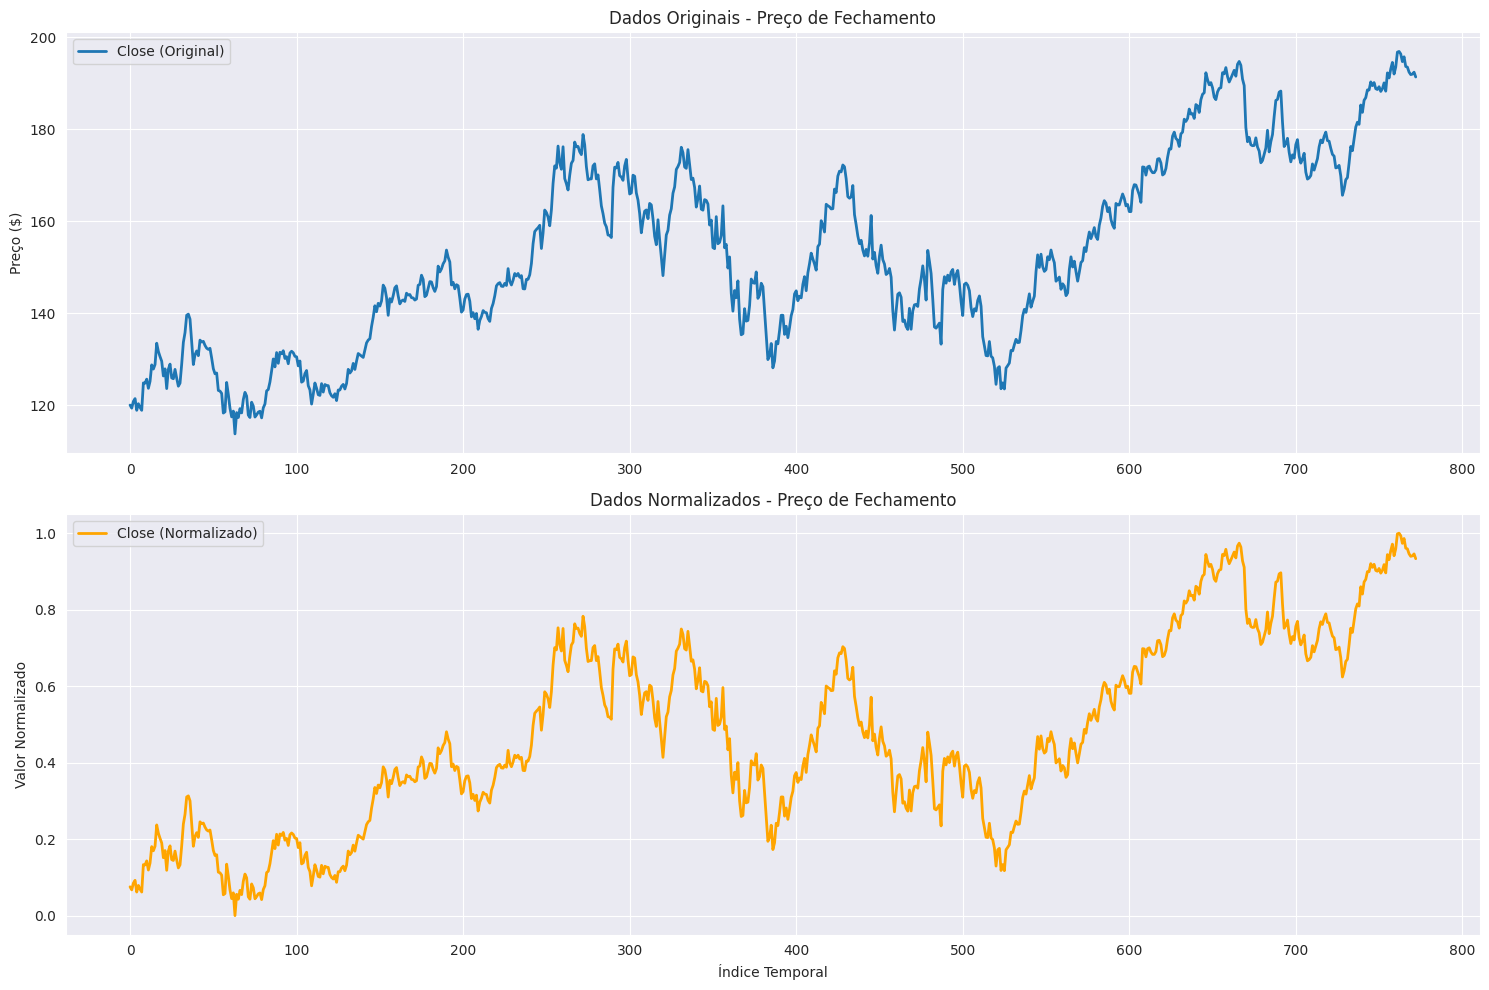

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Dados originais
axes[0].plot(data[:, 3], label='Close (Original)', linewidth=2)
axes[0].set_title('Dados Originais - Preço de Fechamento')
axes[0].set_ylabel('Preço ($)')
axes[0].legend()
axes[0].grid(True)

# Dados normalizados
axes[1].plot(scaled_data[:, 3], label='Close (Normalizado)', linewidth=2, color='orange')
axes[1].set_title('Dados Normalizados - Preço de Fechamento')
axes[1].set_ylabel('Valor Normalizado')
axes[1].set_xlabel('Índice Temporal')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 7. Criar Sequências Temporais

In [9]:
def create_sequences(data, seq_length, target_col_idx=3):
    """Cria sequências temporais para LSTM"""
    X, y = [], []
    
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :])
        y.append(data[i, target_col_idx])
    
    return np.array(X), np.array(y)

# Criar sequências
X, y = create_sequences(scaled_data, SEQUENCE_LENGTH)

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"\nInterpretação:")
print(f"- {X.shape[0]} sequências")
print(f"- {X.shape[1]} timesteps por sequência")
print(f"- {X.shape[2]} features por timestep")

Shape de X: (713, 60, 5)
Shape de y: (713,)

Interpretação:
- 713 sequências
- 60 timesteps por sequência
- 5 features por timestep


## 8. Dividir em Treino e Teste

In [10]:
# Dividir mantendo ordem temporal
split_idx = int(len(X) * TRAIN_SPLIT)

X_train = X[:split_idx]
y_train = y[:split_idx]
X_test = X[split_idx:]
y_test = y[split_idx:]

print(f"Conjunto de Treino:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"\nConjunto de Teste:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")
print(f"\nProporção: {TRAIN_SPLIT*100:.0f}% treino / {(1-TRAIN_SPLIT)*100:.0f}% teste")

Conjunto de Treino:
  X_train: (570, 60, 5)
  y_train: (570,)

Conjunto de Teste:
  X_test: (143, 60, 5)
  y_test: (143,)

Proporção: 80% treino / 20% teste


## 9. Visualizar Divisão Treino/Teste

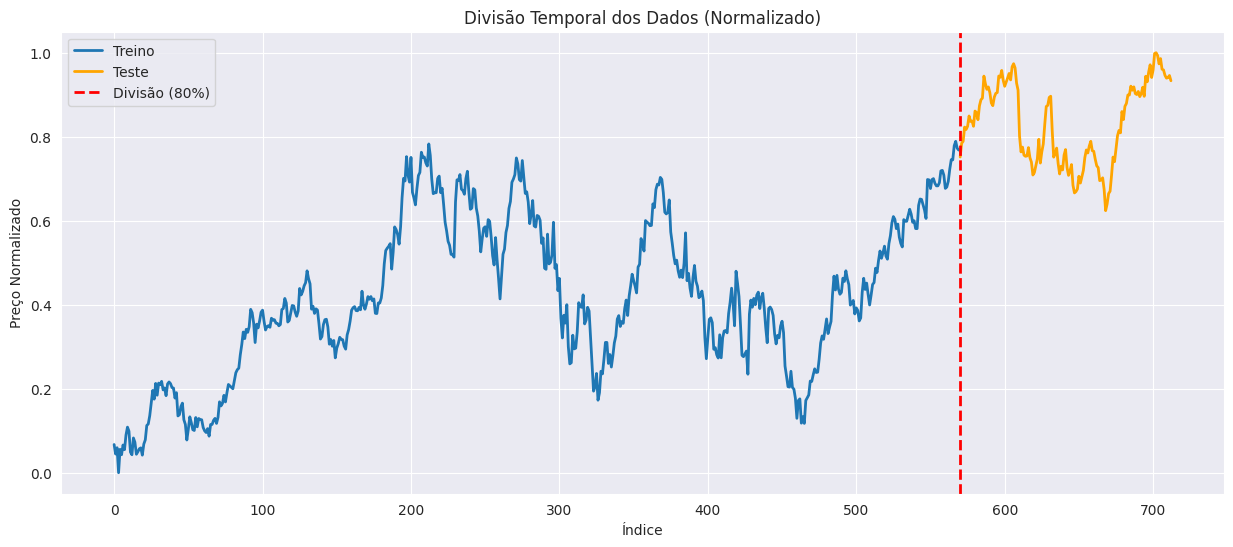

In [11]:
plt.figure(figsize=(15, 6))

# Plotar divisão
plt.plot(range(len(y_train)), y_train, label='Treino', linewidth=2)
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, 
         label='Teste', linewidth=2, color='orange')

plt.axvline(x=len(y_train), color='r', linestyle='--', linewidth=2, 
            label=f'Divisão ({TRAIN_SPLIT*100:.0f}%)')

plt.title('Divisão Temporal dos Dados (Normalizado)')
plt.xlabel('Índice')
plt.ylabel('Preço Normalizado')
plt.legend()
plt.grid(True)
plt.show()

## 10. Salvar Dados Preprocessados

In [12]:
import pickle
import os

# Criar diretório
os.makedirs('../data/processed', exist_ok=True)

# Salvar arrays
np.save('../data/processed/X_train.npy', X_train)
np.save('../data/processed/y_train.npy', y_train)
np.save('../data/processed/X_test.npy', X_test)
np.save('../data/processed/y_test.npy', y_test)

# Salvar scaler
with open('../data/processed/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("✅ Dados preprocessados salvos em data/processed/")
print("\nArquivos criados:")
print("  - X_train.npy")
print("  - y_train.npy")
print("  - X_test.npy")
print("  - y_test.npy")
print("  - scaler.pkl")

✅ Dados preprocessados salvos em data/processed/

Arquivos criados:
  - X_train.npy
  - y_train.npy
  - X_test.npy
  - y_test.npy
  - scaler.pkl


## 📊 Resumo do Pré-processamento

**Etapas realizadas:**
1. ✅ Carregamento dos dados históricos
2. ✅ Adição de indicadores técnicos
3. ✅ Normalização com MinMaxScaler
4. ✅ Criação de sequências temporais
5. ✅ Divisão treino/teste temporal
6. ✅ Salvamento dos dados processados

**Próximo passo:** Notebook 03 - Treinamento do Modelo